# Testing Predictive Model Performance Using Binary And Multi-Class Classification

## Using NFL Play by Play Data to Predict Yards Gained

The target class is yards gained. The attribute is binarized as follows:

### Binary Lables
> Trial 1 (1plus):
>> 0 = No Gain

>> 1 = Gain of 1 or more yards

> Trial 2 (10plus):
>> 0 = 9 or Less Yards

>> 1 = 10 or More Yards

> Trial 3 (20plus):
>> 0 = 19 or less Yards

>> 1 = 20 or more Yards

### Multi-Class 
> Trial 4 (4Class):
>>0 = No Gain

>>1 = 1-9 Yards

>>2 = 10-19 Yards

>>3 = 20 + Yard



In [1]:
#Import Dependencies
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
import math
import collections
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report,confusion_matrix

File_Loc ="../input/"

#Import NFL Play by Play data set
D = pd.read_csv(File_Loc + 'NFL2015_Working2.csv')

#Import NFL Player Roster data set (for encoding purposes)
P = pd.read_csv(File_Loc + 'Players.csv')

#Import NFL Team List data set (for encoding purposes)
T = pd.read_csv(File_Loc + 'Teams.csv')

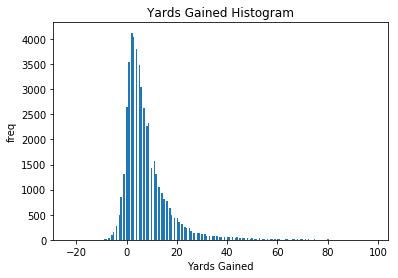

,Drive,qtr,down,TimeUnder,PlayTimeDiff,SideofField,yrdline100,ydstogo,ydsnet,GoalToGo,...,PassLocation,RunLocation,RunGap,PosTeamWinning,AbsScoreDiff,Yards.Gained,Yards.Gained.Cat.10Plus,Yards.Gained.Cat.20Plus,Yards.Gained.Cat.4Class,Yards.Gained.Cat.1Plus
0,23,4,4,1,0.0,BAL,77,8,-21,0,...,NaN,middle,NaN,1,7,-23,0,0,0,0
1,15,3,3,14,37.0,SF,69,4,-10,0,...,left,NaN,NaN,1,14,-16,0,0,0,0
2,3,1,1,11,0.0,PHI,80,10,-12,0,...,NaN,right,end,0,3,-12,0,0,0,0
3,5,2,1,15,0.0,CAR,68,10,0,0,...,NaN,left,end,0,4,-12,0,0,0,0
4,16,3,2,10,36.0,PIT,58,7,-9,0,...,NaN,left,end,0,7,-12,0,0,0,0
5,26,4,3,4,8.0,MID,50,22,17,0,...,middle,NaN,NaN,0,19,-11,0,0,0,0
6,2,1,1,9,30.0,WAS,41,10,3,0,...,NaN,right,end,1,7,-11,0,0,0,0
7,22,4,1,7,27.0,BUF,80,10,1,0,...,NaN,middle,NaN,0,0,-10,0,0,0,0
8,18,4,1,10,8.0,BUF,80,10,-10,0,...,NaN,right,end,1,3,-10,0,0,0,0
9,14,3,4,13,38.0,BUF,80,15,29,0,...,NaN,NaN,NaN,0,21,-10,0,0,0,0


In [2]:
#Visualize the distribution target value "Yards.Gained"
plt.hist(D["Yards.Gained"],bins=200)
plt.xlabel("Yards Gained")
plt.ylabel("freq")
plt.title("Yards Gained Histogram")
plt.show()

#View preview of data prefore any transformations are applied
D.head(n=50)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
        
#CUSTOM DATA TRANSFORMATION CLASS: Encodes the values of specified columns of a dataframe        
class BulkEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,Cols,Base,Bundle):
        self.Cols = Cols
        self.Base = Base
        self.Bundle = Bundle
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        le =LabelEncoder()
        if self.Bundle == "yes":
            le.fit(self.Base)
            for c in self.Cols:
                x[c] = le.transform(x[c])
        elif self.Bundle == "no":
            for c in self.Cols:
                le.fit(x[c])
                x[c] = le.transform(x[c])
        return x
    

#fill in missing strings with and x and missing int with 0
D = D.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna("x"))


#Transformation pipeline
PreProcessing_Pipline = Pipeline(
  [

    # - encode all columns containing the name of players as an int
   ("team_encoder",BulkEncoder(["posteam","DefensiveTeam","SideofField"]
                               ,T["Teams"],"yes")),
   ("misc_encoder",BulkEncoder(["RunLocation","RunGap","PlayType",
                                "PassLength","PassLocation"],"none","no")),  
  ]
)

#Transformed dataset
D = PreProcessing_Pipline.fit_transform(D)

In [4]:
#Splitting data set into test and train for each trial
x  = D.iloc[:,0:19]
Predictors = list(x.columns.values)
print(Predictors)
y1 = D['Yards.Gained.Cat.20Plus']
y2 = D['Yards.Gained.Cat.10Plus']
y3 = D['Yards.Gained.Cat.4Class']
y4 = D["Yards.Gained.Cat.1Plus"]

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y1
                                                        ,test_size=0.20
                                                        ,shuffle=True
                                                        ,random_state=2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y2
                                                        ,test_size=0.20
                                                        ,shuffle=True
                                                        ,random_state=2)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y3
                                                        ,test_size=0.20
                                                        ,shuffle=True
                                                        ,random_state=2)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y4
                                                        ,test_size=0.20
                                                        ,shuffle=True
                                                        ,random_state=2)

['Drive', 'qtr', 'down', 'TimeUnder', 'PlayTimeDiff', 'SideofField', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'posteam', 'DefensiveTeam', 'PlayType', 'PassLength', 'PassLocation', 'RunLocation', 'RunGap', 'PosTeamWinning', 'AbsScoreDiff']


In [5]:
#Dictionaries to house the scores from out trials with different models
import json
Trials = ['1Plus','10Plus','20Plus','4Class']

Training_And_Testing_Sets = {'Train':
                                     {
                                      'Data':{
                                               '20Plus':x_train1
                                               ,'10Plus':x_train2
                                               ,'4Class':x_train3
                                               ,'1Plus':x_train4
                                              }
                                      ,'Target':{
                                               '20Plus':y_train1
                                               ,'10Plus':y_train2
                                               ,'4Class':y_train3
                                               ,'1Plus':y_train4
                                               }
                                     }
                             ,'Test':
                                     {
                                      'Data':{
                                               '20Plus':x_test1
                                               ,'10Plus':x_test2
                                               ,'4Class':x_test3
                                               ,'1Plus':x_test4
                                              }
                                      ,'Target':{
                                               '20Plus':y_test1
                                               ,'10Plus':y_test2
                                               ,'4Class':y_test3
                                               ,'1Plus':y_test4
                                               }
                                     }
                            }

Model_Scores = {
            'multi-label':{'Acc':{}
                          ,'Pr':{}
                          ,'RC':{}
                           ,'F1':{}
            }
           ,'20Plus':{'Acc':{}
                     ,'Pr':{}
                     ,'RC':{}
                     ,'F1':{}}
           ,'10Plus':{'Acc':{}
                     ,'Pr':{}
                     ,'RC':{}
                     ,'F1':{}}
           ,'4Class':{'Acc':{}
                     ,'Pr':{}
                     ,'RC':{}
                     ,'F1':{}}
         ,'1Plus':{'Acc':{}
                     ,'Pr':{}
                     ,'RC':{}
                     ,'F1':{}}
}

## Models: Multi-Layer Perceptron - Random Forest - Support Vector Machine

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report
from sklearn.multiclass import OneVsRestClassifier

KNN = KNeighborsClassifier(weights='distance',n_neighbors=2000)
MLP = MLPClassifier(activation='relu'
                       ,hidden_layer_sizes=(10,10,10)
                       ,max_iter=2000
                       ,verbose=False
                       ,batch_size=350
                       ,random_state=1
                       ,warm_start= False
                       )
RF = RandomForestClassifier(n_estimators=1000,max_depth=25
                            ,criterion='gini')
SVM = OneVsRestClassifier(SVC())

TrialModel = {
                'MLP': MLP
               ,'Random Forest': RF 
               ,'SVM': SVM
               
}
    
FeatureImportance = []
for Trial in Trials:
    train_x = Training_And_Testing_Sets['Train']['Data'][Trial]
    train_y = Training_And_Testing_Sets['Train']['Target'][Trial] 
    test_y  = Training_And_Testing_Sets['Test']['Target'][Trial]
    test_x  = Training_And_Testing_Sets['Test']['Data'][Trial]
    
    acc_list = []
    pr_list = []
    rc_list = []
    F1_list = []
    for TR in TrialModel:
        print(TR,": ", Trial)
        Model = TrialModel[TR]
        Model.fit(train_x,train_y)
        Prediction = Model.predict(test_x)
        Prediction1 = Model.predict(train_x)
        if hasattr(Model,'feature_importances_'):
            FeatureImportance.append(Model.feature_importances_)
        print("Accuracy test: ", accuracy_score(test_y,Prediction)*100,'%')
        print("Accuracy Train: ", accuracy_score(train_y,Prediction1)*100,'%')
        print("Precision ",precision_recall_fscore_support(test_y,Prediction,average=None)[0])
        print("Recall ",precision_recall_fscore_support(test_y,Prediction,average=None)[1])
        print("f1 ",precision_recall_fscore_support(test_y,Prediction,average=None)[2])
        acc_list.append(accuracy_score(test_y,Prediction))
        pr,rc,f1,sup = precision_recall_fscore_support(test_y,Prediction,average=None)
        print(classification_report(test_y,Prediction))
        pr_list.append(pr.tolist())
        rc_list.append(rc.tolist())
        F1_list.append(f1.tolist())
        print(' ')
        print(' ')
    Model_Scores[Trial]['Acc']=acc_list
    Model_Scores[Trial]['Pr']=pr_list
    Model_Scores[Trial]['RC']=rc_list
    Model_Scores[Trial]['F1']=F1_list


MLP :  1Plus
Accuracy test:  91.8877236274 %
Accuracy Train:  91.5706940874 %
Precision  [ 0.92424242  0.91860967]
Recall  [ 0.361558    0.99590404]
f1  [ 0.51978089  0.95569656]
             precision    recall  f1-score   support

          0       0.92      0.36      0.52      1181
          1       0.92      1.00      0.96      8545

avg / total       0.92      0.92      0.90      9726

 
 
Random Forest :  1Plus
Accuracy test:  91.3325107958 %
Accuracy Train:  99.7532133676 %
Precision  [ 0.8673913   0.91560544]
Recall  [ 0.33784928  0.99286132]
f1  [ 0.48628885  0.9526697 ]
             precision    recall  f1-score   support

          0       0.87      0.34      0.49      1181
          1       0.92      0.99      0.95      8545

avg / total       0.91      0.91      0.90      9726

 
 
SVM :  1Plus
Accuracy test:  87.8572897388 %
Accuracy Train:  87.8946015424 %
Precision  [ 0.5         0.87872866]
Recall  [ 0.00169348  0.99976594]
f1  [ 0.00337553  0.9353479 ]
             pr

In [7]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = float(rect.get_height())
        ax.text(rect.get_x() + rect.get_width()/4., 1.05*height,
                '%d' % float(height),
                ha='left', va='bottom')

## Feature Importance

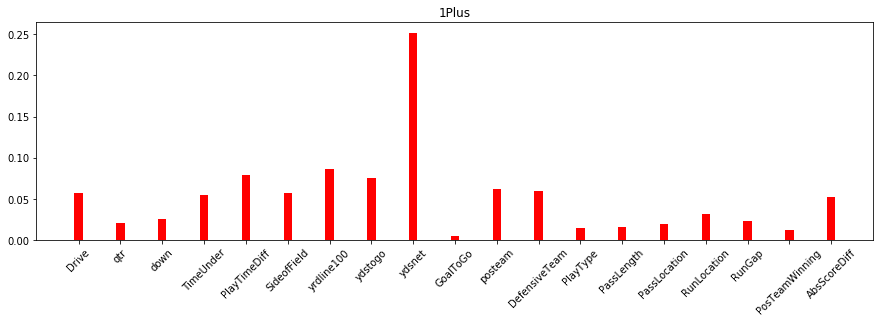

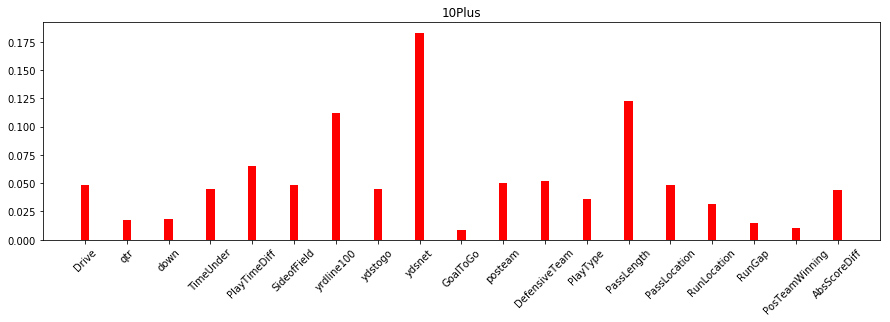

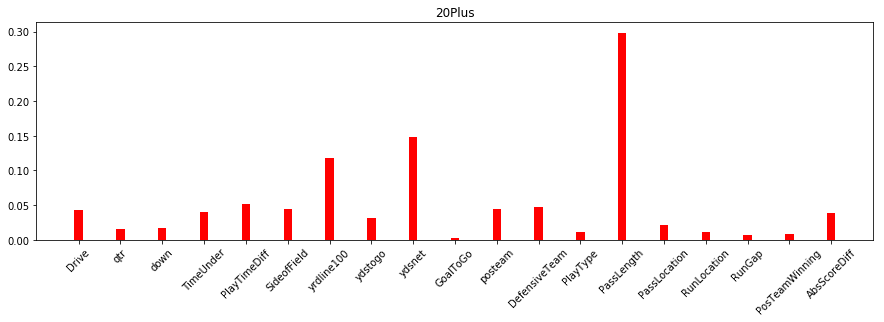

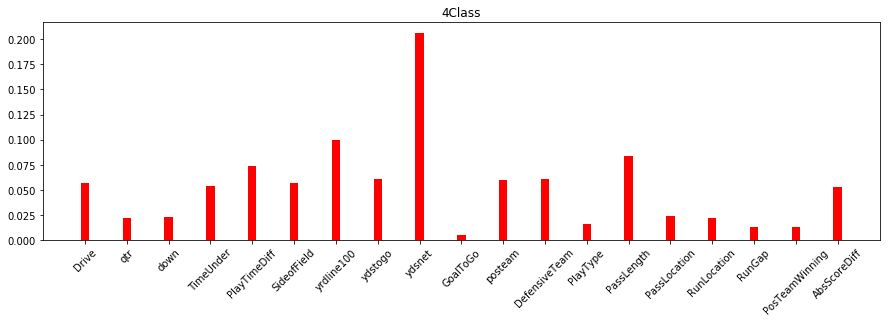

In [8]:

N = 19


ind = np.arange(N)  # the x locations for the groups
width = 0.20       # the width of the bars

for i in range(len(FeatureImportance)):
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, FeatureImportance[i].tolist(), width, color='r')
    ax.set_xticks(ind)
    ax.set_title(Trials[i])
    ax.set_xticklabels(Predictors,rotation=45)
    fig.set_figwidth(15)  
    plt.show()

## Model Accuracies

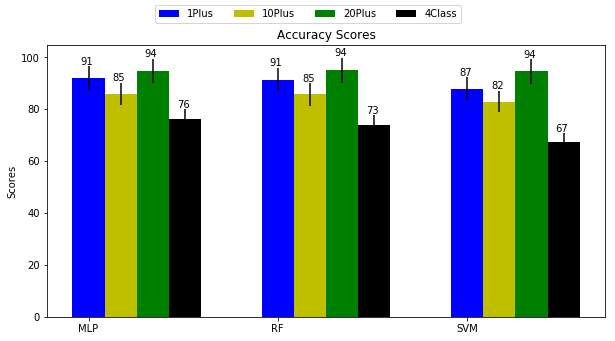

In [9]:
N = 3
Trials = ['1Plus','10Plus','20Plus','4Class']


P1 = [i*100 for i in Model_Scores['1Plus']['Acc']]
P1V = [.05*i for i in P1]
P10 = [i*100 for i in Model_Scores['10Plus']['Acc']]
P10V = [.05*i for i in P10]
P20 = [i*100 for i in Model_Scores['20Plus']['Acc']]
P20V = [.05*i for i in P20]
C3 = [i*100 for i in Model_Scores['4Class']['Acc']]
C3V = [.05*i for i in C3]

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(ind + width, P1, width, color='b',yerr=P1V)
rects3 = ax.bar(ind + width + width, P10, width, color='y',yerr=P10V)
rects4 = ax.bar(ind + width + width + width, P20, width, color='g',yerr=P20V)
rects5 = ax.bar(ind + width + width + width + width, C3, width, color='k',yerr=C3V)
# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Accuracy Scores')
ax.set_xticks(ind + width)
ax.set_xticklabels(('MLP', 'RF', 'SVM'))


autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
fig.set_figheight(5)
fig.set_figwidth(10)  
fig.legend(( rects2[0],rects3[0],rects4[0],rects5[0]), Trials, ncol=5,loc="upper center")

plt.show()

## Precision - Recal - F1 Score

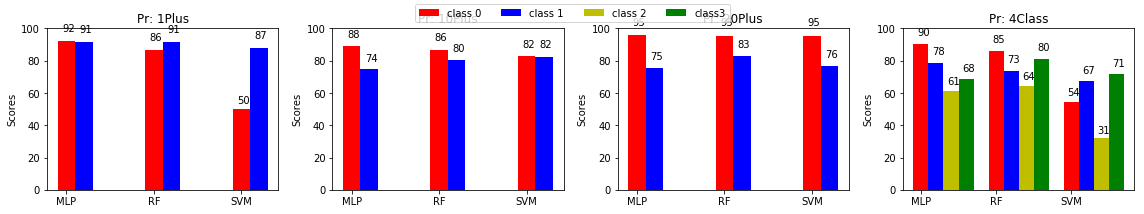

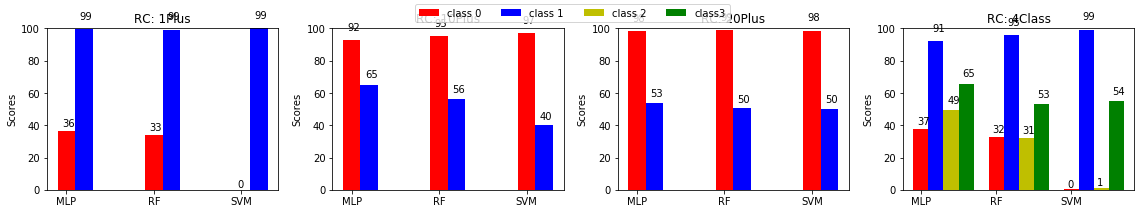

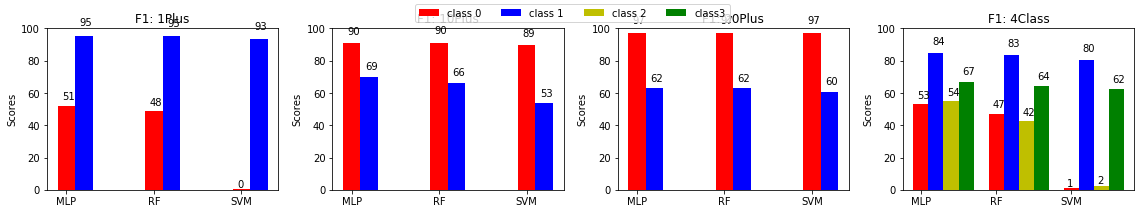

In [10]:
N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.20       # the width of the bars
w=width
metrics = ['Pr','RC','F1']
Barcolors = ['r','b','t']

for metric in metrics:
        fig, axes = plt.subplots(nrows=1, ncols=4)
        for ax,Trial in zip(axes.flat[0:],Trials):               
                #for i in range(0,2):
                #w=width*i 
                scores = [x[0]*100 for x in Model_Scores[Trial][metric]]
                scores2 =  [x[1]*100 for x in Model_Scores[Trial][metric]]              
                rects1 = ax.bar(ind + w, scores, width, color='r')
                rects2 = ax.bar(ind + w + w, scores2, width, color='b')
                if Trial == "4Class":
                    scores3 =  [x[2]*100 for x in Model_Scores[Trial][metric]]
                    rects3 = ax.bar(ind + w + w + w, scores3, width, color='y')
                    scores4=  [x[3]*100 for x in Model_Scores[Trial][metric]]
                    rects4 = ax.bar(ind + w + w + w + w, scores4, width, color='g')
                ax.set_ylim(0,100)
                ax.set_ylabel('Scores')
                ax.set_title(metric+': '+Trial)
                ax.set_xticks(ind + width)
                ax.set_xticklabels(('MLP', 'RF', 'SVM'))
                autolabel(rects1)
                autolabel(rects2)
                if Trial == '4Class':
                    autolabel(rects3)
                    autolabel(rects4)
        fig.set_figheight(3)
        fig.set_figwidth(16)
        fig.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ['class 0','class 1','class 2','class3']
                   , ncol=4,loc="upper center")
        fig.tight_layout()   
        plt.show()